In [2]:
from IPython.display import SVG, display, HTML
import msprime
import tskit
import numpy as np
import matplotlib.pyplot as plt

In [12]:
%%time
ts = msprime.simulate(
    sample_size=10**5, length=1e7, recombination_rate=1e-8, mutation_rate=1e-8,
    Ne=10**4, random_seed=42)

CPU times: user 4.05 s, sys: 28.2 ms, total: 4.08 s
Wall time: 4.08 s


## Incremental calculations

The tree sequence data structure is efficient because it captures the shared structure between adjacent trees. Understanding how trees change as we move across the sequence is also critical for defining efficient algorithms.

Consider the problem of computing the total branch length. In a single tree, all we can do is to iterate over all the nodes and sum the length of each branch. If we repeat this for every tree in the sequence, this ends up being a slow operation:

In [5]:
%%time
total_branch_length = np.zeros(ts.num_trees)
for tree in ts.trees():
    total_branch_length[tree.index] = tree.total_branch_length
    if tree.index == 50:
        break

print(total_branch_length[:5])

[571111.36722641 570906.04178704 570929.28798328 570929.26852078
 570842.83922985]
CPU times: user 18.8 s, sys: 1.38 ms, total: 18.8 s
Wall time: 18.8 s


Here it takes tens of seconds to compute the total branch length for the first 50 trees --- these are large trees with 200K nodes! Since there are about 1000 times more trees than this, it will take a long time to compute the total branch length for all trees.

However, we can do much better than this. As we noted in the introductory section, the edge_diffs() method returns an iterator over the edges that are inserted and removed for each tree in turn. Trees don't change very much as we move across the tree sequence; in fact, for coalescent trees, we know that there are at most four edges that are removed and inserted at each tree transition. By taking this information into account, we can compute the total branch length for all trees in a tiny fraction of the time:

In [6]:
%time
current = 0
total_branch_length = np.zeros(ts.num_trees)
node_time = ts.tables.nodes.time
for j, (_, edges_out, edges_in) in enumerate(ts.edge_diffs()):
    for e in edges_out:
        current -= node_time[e.parent] - node_time[e.child]
    for e in edges_in:
        current += node_time[e.parent] - node_time[e.child]
    total_branch_length[j] = current

print(total_branch_length[:5])

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs
[571111.36722641 570906.04178704 570929.28798328 570929.26852078
 570842.83922985]


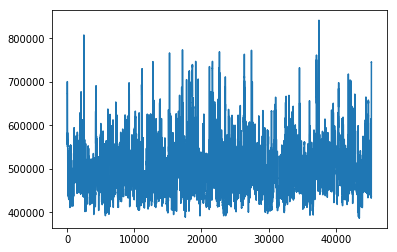

In [7]:
plt.plot(total_branch_length);

## Tables API

The tables API provides a very efficient way of getting at the underlying numerical data representing the tree sequence. Suppose we wished to plot the distribution of the length of the edges in the simulation (an edge is a (left, right, parent, child) tuple describing a branch in the trees spanning the interval from left to right).

See the [documentation](https://tskit.readthedocs.io/en/latest/python-api.html#tables) on this API.

In [13]:
%%time
tables = ts.tables
edge_length = tables.edges.right - tables.edges.left

CPU times: user 2.86 ms, sys: 3.66 ms, total: 6.52 ms
Wall time: 5.51 ms


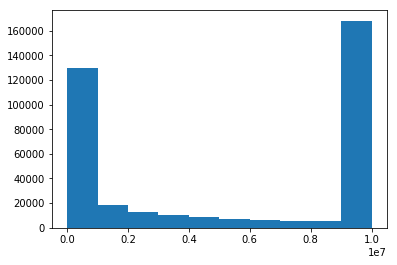

In [14]:
plt.hist(edge_length);



We can also use this to access information about the sites and mutations (which are in their own respective tables --- see the data model for details). Here, for example, we get an array of the time of each mutation (or, more accurately, the time of the node over which each mutation occured), find how many of these are old and plot their age distribution.

In [15]:
oldest_time = np.max(tables.nodes.time)
mutation_time = tables.nodes.time[tables.mutations.node]
index = mutation_time > (oldest_time / 10)
print("number of mutations older than 10% of the oldest time = ", np.sum(index))

number of mutations older than 10% of the oldest time =  856


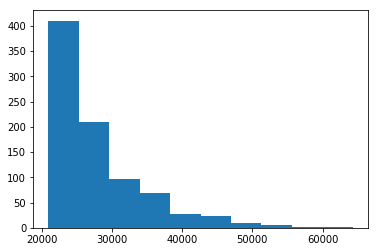

In [16]:
plt.hist(mutation_time[index]);